# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')

In [6]:
np.shape(varftrain)

(7000, 10, 2, 100)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(2000, 10, 2, 100)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(1000, 10, 2, 100)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation=custom_activation)
])

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l1, l2

# Initialize the model
model = Sequential()

# Flatten for dense layers (assuming input shape is 2D)
model.add(Flatten(input_shape=(10, 2, 100)))

# First dense layer
if True:  # add_batch_norm_before_dense_1
    model.add(BatchNormalization())
model.add(Dense(85, activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))

# Second dense layer
if False:  # add_batch_norm_before_dense_2
    model.add(BatchNormalization())
model.add(Dense(22, activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(0.001)))

# Third dense layer
if True:  # add_batch_norm_before_dense_3
    model.add(BatchNormalization())
model.add(Dense(58, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
if True:  # add_dropout_after_dense_3
    model.add(Dropout(0.13555329635761065))

# Fourth dense layer
if True:  # add_batch_norm_before_dense_4
    model.add(BatchNormalization())
model.add(Dense(52, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))

# Fifth dense layer
if False:  # add_batch_norm_before_dense_5
    model.add(BatchNormalization())
model.add(Dense(72, activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001)))

# Output dense layer (Assuming the same as before)

model.add(Dense(7, activation=custom_activation))

# Display model architecture to verify
# model.summary()


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2000)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 2000)             8000      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 85)                170085    
                                                                 
 dense_6 (Dense)             (None, 22)                1892      
                                                                 
 batch_normalization_3 (Batc  (None, 22)               88        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 58)               

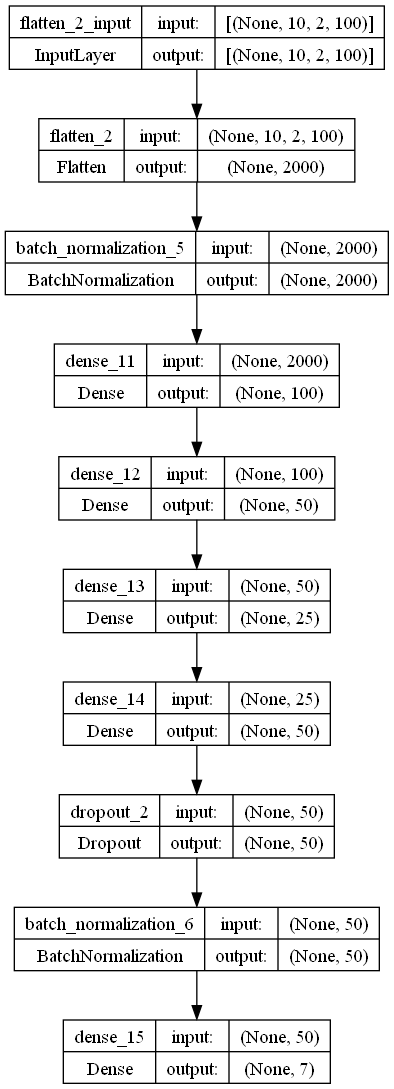

In [41]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [42]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [43]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [44]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [45]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [46]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166
def adaptive_learning_rate(epoch):
    initial_lr = 0.001
    final_lr = 0.00001  # Updated final learning rate
    start_decay_epoch = 100
    end_decay_epoch = 1000
    
    if epoch < start_decay_epoch:
        return initial_lr
    elif epoch >= start_decay_epoch and epoch <= end_decay_epoch:
        lr_range = initial_lr - final_lr
        decay_epochs = end_decay_epoch - start_decay_epoch
        decay_per_epoch = lr_range / decay_epochs
        return initial_lr - (epoch - start_decay_epoch) * decay_per_epoch
    else:
        return final_lr

In [47]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 100,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 6ms/step - loss: 15.8772 - a_1: 2.9790 - a_2: 3.0029 - b_1: 2.7975 - b_2: 2.7895 - d_1: 1.5983 - d_2: 1.8678 - n: 2.4821 - mean_metric: 0.5805 - val_loss: 15.3315 - val_a_1: 2.8845 - val_a_2: 2.6803 - val_b_1: 2.9096 - val_b_2: 2.5284 - val_d_1: 2.5872 - val_d_2: 2.3246 - val_n: 2.0495 - val_mean_metric: 0.5893 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 0s 3ms/step - loss: 13.4450 - a_1: 2.8729 - a_2: 2.8649 - b_1: 2.6240 - b_2: 2.6070 - d_1: 1.3821 - d_2: 1.4293 - n: 1.9454 - mean_metric: 0.5214 - val_loss: 12.2878 - val_a_1: 2.7509 - val_a_2: 2.6683 - val_b_1: 2.6864 - val_b_2: 2.4303 - val_d_1: 1.3506 - val_d_2: 1.6733 - val_n: 1.6752 - val_mean_metric: 0.4999 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 0s 3ms/step - loss: 11.9695 - a_1: 2.8347 - a_2: 2.7969 - b_1: 2.5383 - b_2: 2.5023 - d_1: 1.2557 - d_2: 1.2529 - n: 1.6923 - mean_metric: 0.4931 - val_loss: 10.8249 - val_a_1: 2.7

70/70 [==============================] - 0s 3ms/step - loss: 5.6708 - a_1: 2.5151 - a_2: 2.4970 - b_1: 1.8256 - b_2: 1.7684 - d_1: 0.7424 - d_2: 0.7170 - n: 1.4473 - mean_metric: 0.3817 - val_loss: 5.4235 - val_a_1: 2.4866 - val_a_2: 2.4773 - val_b_1: 1.7894 - val_b_2: 1.6613 - val_d_1: 0.5634 - val_d_2: 0.5521 - val_n: 1.4278 - val_mean_metric: 0.3596 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 0s 3ms/step - loss: 5.6386 - a_1: 2.5035 - a_2: 2.4937 - b_1: 1.7977 - b_2: 1.7619 - d_1: 0.7263 - d_2: 0.7340 - n: 1.4410 - mean_metric: 0.3798 - val_loss: 5.3621 - val_a_1: 2.5058 - val_a_2: 2.4429 - val_b_1: 1.7305 - val_b_2: 1.6525 - val_d_1: 0.5258 - val_d_2: 0.5941 - val_n: 1.4143 - val_mean_metric: 0.3565 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 0s 3ms/step - loss: 5.6137 - a_1: 2.5065 - a_2: 2.4951 - b_1: 1.7923 - b_2: 1.7610 - d_1: 0.7153 - d_2: 0.7028 - n: 1.4429 - mean_metric: 0.3784 - val_loss: 5.3337 - val_a_1: 2.4890 - val_a_2: 2.

70/70 [==============================] - 0s 3ms/step - loss: 4.8838 - a_1: 2.4953 - a_2: 2.4783 - b_1: 1.6617 - b_2: 1.6027 - d_1: 0.6916 - d_2: 0.6620 - n: 1.4334 - mean_metric: 0.3655 - val_loss: 4.7042 - val_a_1: 2.4898 - val_a_2: 2.4372 - val_b_1: 1.5369 - val_b_2: 1.6501 - val_d_1: 0.5013 - val_d_2: 0.5460 - val_n: 1.4025 - val_mean_metric: 0.3467 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.9060 - a_1: 2.5043 - a_2: 2.4687 - b_1: 1.6836 - b_2: 1.6252 - d_1: 0.6664 - d_2: 0.6573 - n: 1.4347 - mean_metric: 0.3659 - val_loss: 4.7005 - val_a_1: 2.4523 - val_a_2: 2.4427 - val_b_1: 1.6432 - val_b_2: 1.5534 - val_d_1: 0.5348 - val_d_2: 0.5492 - val_n: 1.3981 - val_mean_metric: 0.3470 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.8629 - a_1: 2.5033 - a_2: 2.4677 - b_1: 1.6482 - b_2: 1.6136 - d_1: 0.6686 - d_2: 0.6393 - n: 1.4302 - mean_metric: 0.3636 - val_loss: 4.6195 - val_a_1: 2.4797 - val_a_2: 2.

70/70 [==============================] - 0s 3ms/step - loss: 4.6233 - a_1: 2.4799 - a_2: 2.4610 - b_1: 1.5848 - b_2: 1.5283 - d_1: 0.6359 - d_2: 0.6245 - n: 1.4236 - mean_metric: 0.3559 - val_loss: 4.4320 - val_a_1: 2.4420 - val_a_2: 2.4325 - val_b_1: 1.5523 - val_b_2: 1.4413 - val_d_1: 0.4968 - val_d_2: 0.4993 - val_n: 1.3856 - val_mean_metric: 0.3363 - lr: 9.7140e-04
Epoch 128/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.6676 - a_1: 2.4901 - a_2: 2.4538 - b_1: 1.6236 - b_2: 1.5236 - d_1: 0.6482 - d_2: 0.6470 - n: 1.4242 - mean_metric: 0.3583 - val_loss: 4.4121 - val_a_1: 2.4493 - val_a_2: 2.4133 - val_b_1: 1.4786 - val_b_2: 1.5236 - val_d_1: 0.4740 - val_d_2: 0.4345 - val_n: 1.3893 - val_mean_metric: 0.3335 - lr: 9.7030e-04
Epoch 129/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.5935 - a_1: 2.4785 - a_2: 2.4501 - b_1: 1.5933 - b_2: 1.4839 - d_1: 0.6370 - d_2: 0.6269 - n: 1.4225 - mean_metric: 0.3545 - val_loss: 4.4427 - val_a_1: 2.4674 - v

70/70 [==============================] - 0s 3ms/step - loss: 4.4003 - a_1: 2.4446 - a_2: 2.4147 - b_1: 1.4763 - b_2: 1.4718 - d_1: 0.6000 - d_2: 0.6082 - n: 1.4105 - mean_metric: 0.3456 - val_loss: 4.3527 - val_a_1: 2.4309 - val_a_2: 2.4081 - val_b_1: 1.4215 - val_b_2: 1.4812 - val_d_1: 0.4741 - val_d_2: 0.4303 - val_n: 1.3918 - val_mean_metric: 0.3294 - lr: 9.2520e-04
Epoch 170/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.4047 - a_1: 2.4515 - a_2: 2.4360 - b_1: 1.4804 - b_2: 1.4537 - d_1: 0.6015 - d_2: 0.6160 - n: 1.4123 - mean_metric: 0.3464 - val_loss: 4.3962 - val_a_1: 2.4541 - val_a_2: 2.4156 - val_b_1: 1.4722 - val_b_2: 1.4753 - val_d_1: 0.5364 - val_d_2: 0.5508 - val_n: 1.3829 - val_mean_metric: 0.3376 - lr: 9.2410e-04
Epoch 171/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.4292 - a_1: 2.4452 - a_2: 2.4321 - b_1: 1.5070 - b_2: 1.4766 - d_1: 0.6323 - d_2: 0.6073 - n: 1.4078 - mean_metric: 0.3483 - val_loss: 4.3438 - val_a_1: 2.4436 - v

70/70 [==============================] - 0s 3ms/step - loss: 4.3111 - a_1: 2.4279 - a_2: 2.4030 - b_1: 1.4805 - b_2: 1.4131 - d_1: 0.6113 - d_2: 0.5901 - n: 1.4014 - mean_metric: 0.3423 - val_loss: 4.2171 - val_a_1: 2.4031 - val_a_2: 2.3849 - val_b_1: 1.4537 - val_b_2: 1.4425 - val_d_1: 0.4494 - val_d_2: 0.4628 - val_n: 1.3728 - val_mean_metric: 0.3271 - lr: 8.7900e-04
Epoch 212/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.3155 - a_1: 2.4217 - a_2: 2.4001 - b_1: 1.4823 - b_2: 1.4212 - d_1: 0.6125 - d_2: 0.5861 - n: 1.4014 - mean_metric: 0.3422 - val_loss: 4.1923 - val_a_1: 2.4102 - val_a_2: 2.4088 - val_b_1: 1.4221 - val_b_2: 1.3753 - val_d_1: 0.4390 - val_d_2: 0.3964 - val_n: 1.3765 - val_mean_metric: 0.3225 - lr: 8.7790e-04
Epoch 213/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.3075 - a_1: 2.4177 - a_2: 2.4125 - b_1: 1.4666 - b_2: 1.4014 - d_1: 0.6057 - d_2: 0.5907 - n: 1.4037 - mean_metric: 0.3414 - val_loss: 4.1556 - val_a_1: 2.4112 - v

70/70 [==============================] - 0s 3ms/step - loss: 4.2325 - a_1: 2.4173 - a_2: 2.3867 - b_1: 1.4605 - b_2: 1.3616 - d_1: 0.6231 - d_2: 0.5670 - n: 1.3947 - mean_metric: 0.3385 - val_loss: 4.1391 - val_a_1: 2.3904 - val_a_2: 2.4049 - val_b_1: 1.3567 - val_b_2: 1.4031 - val_d_1: 0.5001 - val_d_2: 0.4185 - val_n: 1.3686 - val_mean_metric: 0.3230 - lr: 8.3280e-04
Epoch 254/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.2233 - a_1: 2.4039 - a_2: 2.3969 - b_1: 1.4245 - b_2: 1.3768 - d_1: 0.6120 - d_2: 0.5821 - n: 1.4004 - mean_metric: 0.3381 - val_loss: 4.0317 - val_a_1: 2.3992 - val_a_2: 2.3988 - val_b_1: 1.3048 - val_b_2: 1.2951 - val_d_1: 0.4587 - val_d_2: 0.4756 - val_n: 1.3693 - val_mean_metric: 0.3183 - lr: 8.3170e-04
Epoch 255/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.2206 - a_1: 2.4060 - a_2: 2.3865 - b_1: 1.4252 - b_2: 1.3716 - d_1: 0.6222 - d_2: 0.5815 - n: 1.3980 - mean_metric: 0.3378 - val_loss: 4.1697 - val_a_1: 2.4058 - v

70/70 [==============================] - 0s 3ms/step - loss: 4.1215 - a_1: 2.4017 - a_2: 2.3688 - b_1: 1.4089 - b_2: 1.3228 - d_1: 0.5994 - d_2: 0.5557 - n: 1.3908 - mean_metric: 0.3330 - val_loss: 4.0142 - val_a_1: 2.3935 - val_a_2: 2.3712 - val_b_1: 1.3081 - val_b_2: 1.2747 - val_d_1: 0.4162 - val_d_2: 0.4730 - val_n: 1.3680 - val_mean_metric: 0.3151 - lr: 7.8660e-04
Epoch 296/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.1540 - a_1: 2.4057 - a_2: 2.3688 - b_1: 1.4479 - b_2: 1.3201 - d_1: 0.6296 - d_2: 0.5570 - n: 1.3907 - mean_metric: 0.3355 - val_loss: 4.0117 - val_a_1: 2.4046 - val_a_2: 2.3709 - val_b_1: 1.3338 - val_b_2: 1.3119 - val_d_1: 0.4575 - val_d_2: 0.3482 - val_n: 1.3703 - val_mean_metric: 0.3149 - lr: 7.8550e-04
Epoch 297/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.1699 - a_1: 2.4067 - a_2: 2.3806 - b_1: 1.4253 - b_2: 1.3499 - d_1: 0.5985 - d_2: 0.5829 - n: 1.3932 - mean_metric: 0.3360 - val_loss: 4.0511 - val_a_1: 2.4124 - v

70/70 [==============================] - 0s 3ms/step - loss: 4.1026 - a_1: 2.3888 - a_2: 2.3589 - b_1: 1.4033 - b_2: 1.3067 - d_1: 0.6115 - d_2: 0.5770 - n: 1.3872 - mean_metric: 0.3326 - val_loss: 4.0137 - val_a_1: 2.3745 - val_a_2: 2.3716 - val_b_1: 1.3140 - val_b_2: 1.3127 - val_d_1: 0.4295 - val_d_2: 0.4316 - val_n: 1.3632 - val_mean_metric: 0.3149 - lr: 7.4040e-04
Epoch 338/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.1308 - a_1: 2.4029 - a_2: 2.3655 - b_1: 1.4234 - b_2: 1.3169 - d_1: 0.6200 - d_2: 0.5785 - n: 1.3945 - mean_metric: 0.3349 - val_loss: 4.1079 - val_a_1: 2.4017 - val_a_2: 2.3929 - val_b_1: 1.3992 - val_b_2: 1.2956 - val_d_1: 0.4543 - val_d_2: 0.3768 - val_n: 1.3707 - val_mean_metric: 0.3180 - lr: 7.3930e-04
Epoch 339/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.1041 - a_1: 2.3988 - a_2: 2.3608 - b_1: 1.4151 - b_2: 1.3240 - d_1: 0.5962 - d_2: 0.5667 - n: 1.3839 - mean_metric: 0.3330 - val_loss: 4.1154 - val_a_1: 2.3895 - v

70/70 [==============================] - 0s 3ms/step - loss: 4.0565 - a_1: 2.3973 - a_2: 2.3323 - b_1: 1.3813 - b_2: 1.3236 - d_1: 0.5918 - d_2: 0.5603 - n: 1.3823 - mean_metric: 0.3304 - val_loss: 3.9160 - val_a_1: 2.3760 - val_a_2: 2.3770 - val_b_1: 1.2645 - val_b_2: 1.2405 - val_d_1: 0.4197 - val_d_2: 0.4004 - val_n: 1.3583 - val_mean_metric: 0.3096 - lr: 6.9420e-04
Epoch 380/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.0610 - a_1: 2.3908 - a_2: 2.3432 - b_1: 1.3952 - b_2: 1.3139 - d_1: 0.6010 - d_2: 0.5511 - n: 1.3883 - mean_metric: 0.3309 - val_loss: 3.9493 - val_a_1: 2.3635 - val_a_2: 2.3816 - val_b_1: 1.2729 - val_b_2: 1.2658 - val_d_1: 0.4228 - val_d_2: 0.4277 - val_n: 1.3573 - val_mean_metric: 0.3114 - lr: 6.9310e-04
Epoch 381/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.0739 - a_1: 2.4000 - a_2: 2.3465 - b_1: 1.4121 - b_2: 1.2956 - d_1: 0.6064 - d_2: 0.5581 - n: 1.3887 - mean_metric: 0.3317 - val_loss: 3.9930 - val_a_1: 2.3851 - v

70/70 [==============================] - 0s 3ms/step - loss: 4.0037 - a_1: 2.3960 - a_2: 2.3242 - b_1: 1.3705 - b_2: 1.2881 - d_1: 0.5910 - d_2: 0.5427 - n: 1.3804 - mean_metric: 0.3279 - val_loss: 3.9642 - val_a_1: 2.3813 - val_a_2: 2.3869 - val_b_1: 1.2965 - val_b_2: 1.2561 - val_d_1: 0.4225 - val_d_2: 0.3950 - val_n: 1.3598 - val_mean_metric: 0.3117 - lr: 6.4800e-04
Epoch 422/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9909 - a_1: 2.3876 - a_2: 2.3160 - b_1: 1.3936 - b_2: 1.2630 - d_1: 0.5850 - d_2: 0.5224 - n: 1.3870 - mean_metric: 0.3267 - val_loss: 4.0114 - val_a_1: 2.3803 - val_a_2: 2.3491 - val_b_1: 1.2698 - val_b_2: 1.3724 - val_d_1: 0.4256 - val_d_2: 0.3658 - val_n: 1.3576 - val_mean_metric: 0.3124 - lr: 6.4690e-04
Epoch 423/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.0591 - a_1: 2.3987 - a_2: 2.3285 - b_1: 1.3895 - b_2: 1.3123 - d_1: 0.5994 - d_2: 0.5569 - n: 1.3859 - mean_metric: 0.3306 - val_loss: 3.9992 - val_a_1: 2.3520 - v

70/70 [==============================] - 0s 3ms/step - loss: 3.9668 - a_1: 2.3676 - a_2: 2.3210 - b_1: 1.3588 - b_2: 1.2927 - d_1: 0.5686 - d_2: 0.5549 - n: 1.3781 - mean_metric: 0.3262 - val_loss: 3.9015 - val_a_1: 2.3394 - val_a_2: 2.3521 - val_b_1: 1.3210 - val_b_2: 1.2656 - val_d_1: 0.4176 - val_d_2: 0.4291 - val_n: 1.3540 - val_mean_metric: 0.3110 - lr: 6.0180e-04
Epoch 464/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9793 - a_1: 2.3756 - a_2: 2.3125 - b_1: 1.3569 - b_2: 1.2733 - d_1: 0.5778 - d_2: 0.5698 - n: 1.3852 - mean_metric: 0.3266 - val_loss: 3.9094 - val_a_1: 2.3576 - val_a_2: 2.3867 - val_b_1: 1.2734 - val_b_2: 1.2454 - val_d_1: 0.3994 - val_d_2: 0.3767 - val_n: 1.3651 - val_mean_metric: 0.3086 - lr: 6.0070e-04
Epoch 465/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9873 - a_1: 2.3844 - a_2: 2.3241 - b_1: 1.3590 - b_2: 1.2753 - d_1: 0.5895 - d_2: 0.5604 - n: 1.3816 - mean_metric: 0.3273 - val_loss: 3.9908 - val_a_1: 2.4131 - v

70/70 [==============================] - 0s 3ms/step - loss: 3.9634 - a_1: 2.3771 - a_2: 2.3044 - b_1: 1.3775 - b_2: 1.2705 - d_1: 0.5941 - d_2: 0.5408 - n: 1.3754 - mean_metric: 0.3262 - val_loss: 3.8965 - val_a_1: 2.3407 - val_a_2: 2.3813 - val_b_1: 1.2746 - val_b_2: 1.2516 - val_d_1: 0.4068 - val_d_2: 0.4230 - val_n: 1.3557 - val_mean_metric: 0.3095 - lr: 5.5560e-04
Epoch 506/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9228 - a_1: 2.3714 - a_2: 2.2965 - b_1: 1.3548 - b_2: 1.2562 - d_1: 0.5786 - d_2: 0.5360 - n: 1.3764 - mean_metric: 0.3239 - val_loss: 3.9091 - val_a_1: 2.3374 - val_a_2: 2.3497 - val_b_1: 1.2749 - val_b_2: 1.2922 - val_d_1: 0.3954 - val_d_2: 0.4404 - val_n: 1.3528 - val_mean_metric: 0.3099 - lr: 5.5450e-04
Epoch 507/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9384 - a_1: 2.3660 - a_2: 2.3107 - b_1: 1.3538 - b_2: 1.2805 - d_1: 0.5792 - d_2: 0.5374 - n: 1.3783 - mean_metric: 0.3251 - val_loss: 3.8995 - val_a_1: 2.3488 - v

70/70 [==============================] - 0s 3ms/step - loss: 3.9222 - a_1: 2.3775 - a_2: 2.2950 - b_1: 1.3419 - b_2: 1.2726 - d_1: 0.5789 - d_2: 0.5566 - n: 1.3811 - mean_metric: 0.3250 - val_loss: 3.9150 - val_a_1: 2.3512 - val_a_2: 2.3429 - val_b_1: 1.2709 - val_b_2: 1.3237 - val_d_1: 0.4108 - val_d_2: 0.3613 - val_n: 1.3555 - val_mean_metric: 0.3090 - lr: 5.0940e-04
Epoch 548/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9483 - a_1: 2.3782 - a_2: 2.2941 - b_1: 1.3607 - b_2: 1.2650 - d_1: 0.5879 - d_2: 0.5511 - n: 1.3785 - mean_metric: 0.3253 - val_loss: 3.8811 - val_a_1: 2.3565 - val_a_2: 2.3553 - val_b_1: 1.2704 - val_b_2: 1.2259 - val_d_1: 0.3928 - val_d_2: 0.4744 - val_n: 1.3562 - val_mean_metric: 0.3095 - lr: 5.0830e-04
Epoch 549/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9089 - a_1: 2.3653 - a_2: 2.2823 - b_1: 1.3596 - b_2: 1.2413 - d_1: 0.5800 - d_2: 0.5441 - n: 1.3772 - mean_metric: 0.3233 - val_loss: 3.8647 - val_a_1: 2.3587 - v

70/70 [==============================] - 0s 3ms/step - loss: 3.8944 - a_1: 2.3597 - a_2: 2.2923 - b_1: 1.3470 - b_2: 1.2424 - d_1: 0.5812 - d_2: 0.5360 - n: 1.3799 - mean_metric: 0.3228 - val_loss: 3.9744 - val_a_1: 2.3618 - val_a_2: 2.3709 - val_b_1: 1.3114 - val_b_2: 1.2677 - val_d_1: 0.4047 - val_d_2: 0.3823 - val_n: 1.3646 - val_mean_metric: 0.3105 - lr: 4.6320e-04
Epoch 590/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.8861 - a_1: 2.3555 - a_2: 2.2894 - b_1: 1.3258 - b_2: 1.2526 - d_1: 0.5777 - d_2: 0.5293 - n: 1.3751 - mean_metric: 0.3217 - val_loss: 3.8959 - val_a_1: 2.3670 - val_a_2: 2.3611 - val_b_1: 1.2883 - val_b_2: 1.2378 - val_d_1: 0.3842 - val_d_2: 0.3837 - val_n: 1.3539 - val_mean_metric: 0.3076 - lr: 4.6210e-04
Epoch 591/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9212 - a_1: 2.3760 - a_2: 2.2891 - b_1: 1.3663 - b_2: 1.2566 - d_1: 0.5856 - d_2: 0.5408 - n: 1.3823 - mean_metric: 0.3247 - val_loss: 3.9109 - val_a_1: 2.3520 - v

70/70 [==============================] - 0s 3ms/step - loss: 3.8793 - a_1: 2.3554 - a_2: 2.2729 - b_1: 1.3409 - b_2: 1.2457 - d_1: 0.5772 - d_2: 0.5439 - n: 1.3755 - mean_metric: 0.3219 - val_loss: 3.9170 - val_a_1: 2.3536 - val_a_2: 2.3714 - val_b_1: 1.2827 - val_b_2: 1.2615 - val_d_1: 0.3939 - val_d_2: 0.3933 - val_n: 1.3542 - val_mean_metric: 0.3088 - lr: 4.1700e-04
Epoch 632/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.8343 - a_1: 2.3366 - a_2: 2.2819 - b_1: 1.3074 - b_2: 1.2368 - d_1: 0.5628 - d_2: 0.5434 - n: 1.3778 - mean_metric: 0.3197 - val_loss: 3.9475 - val_a_1: 2.3559 - val_a_2: 2.3798 - val_b_1: 1.2977 - val_b_2: 1.2397 - val_d_1: 0.4134 - val_d_2: 0.3571 - val_n: 1.3587 - val_mean_metric: 0.3085 - lr: 4.1590e-04
Epoch 633/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.8606 - a_1: 2.3481 - a_2: 2.2660 - b_1: 1.3386 - b_2: 1.2533 - d_1: 0.5733 - d_2: 0.5404 - n: 1.3797 - mean_metric: 0.3215 - val_loss: 3.9691 - val_a_1: 2.3705 - v

In [48]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

63/63 [==============================] - 0s 1ms/step - loss: 3.8165 - a_1: 2.3166 - a_2: 2.4093 - b_1: 1.2323 - b_2: 1.1512 - d_1: 0.3782 - d_2: 0.3904 - n: 1.3638 - mean_metric: 0.3055


# Analizamos accuracy y loss

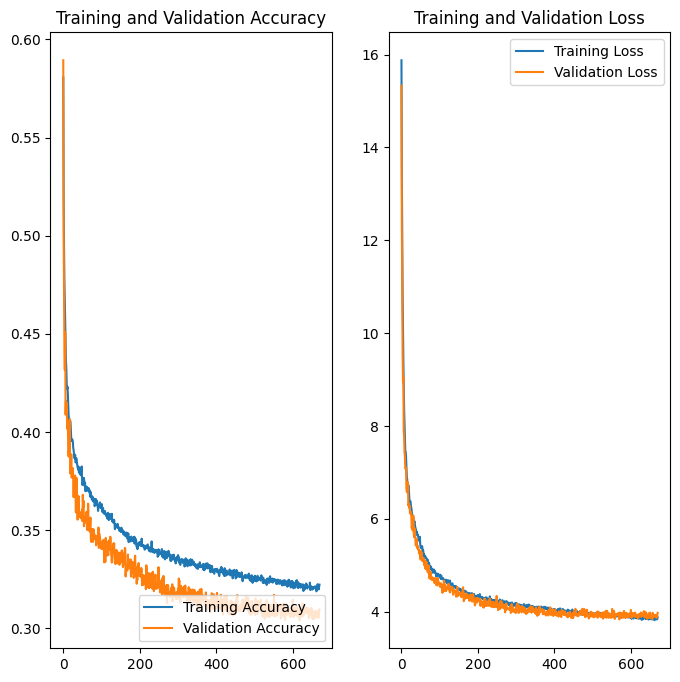

In [50]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(671)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

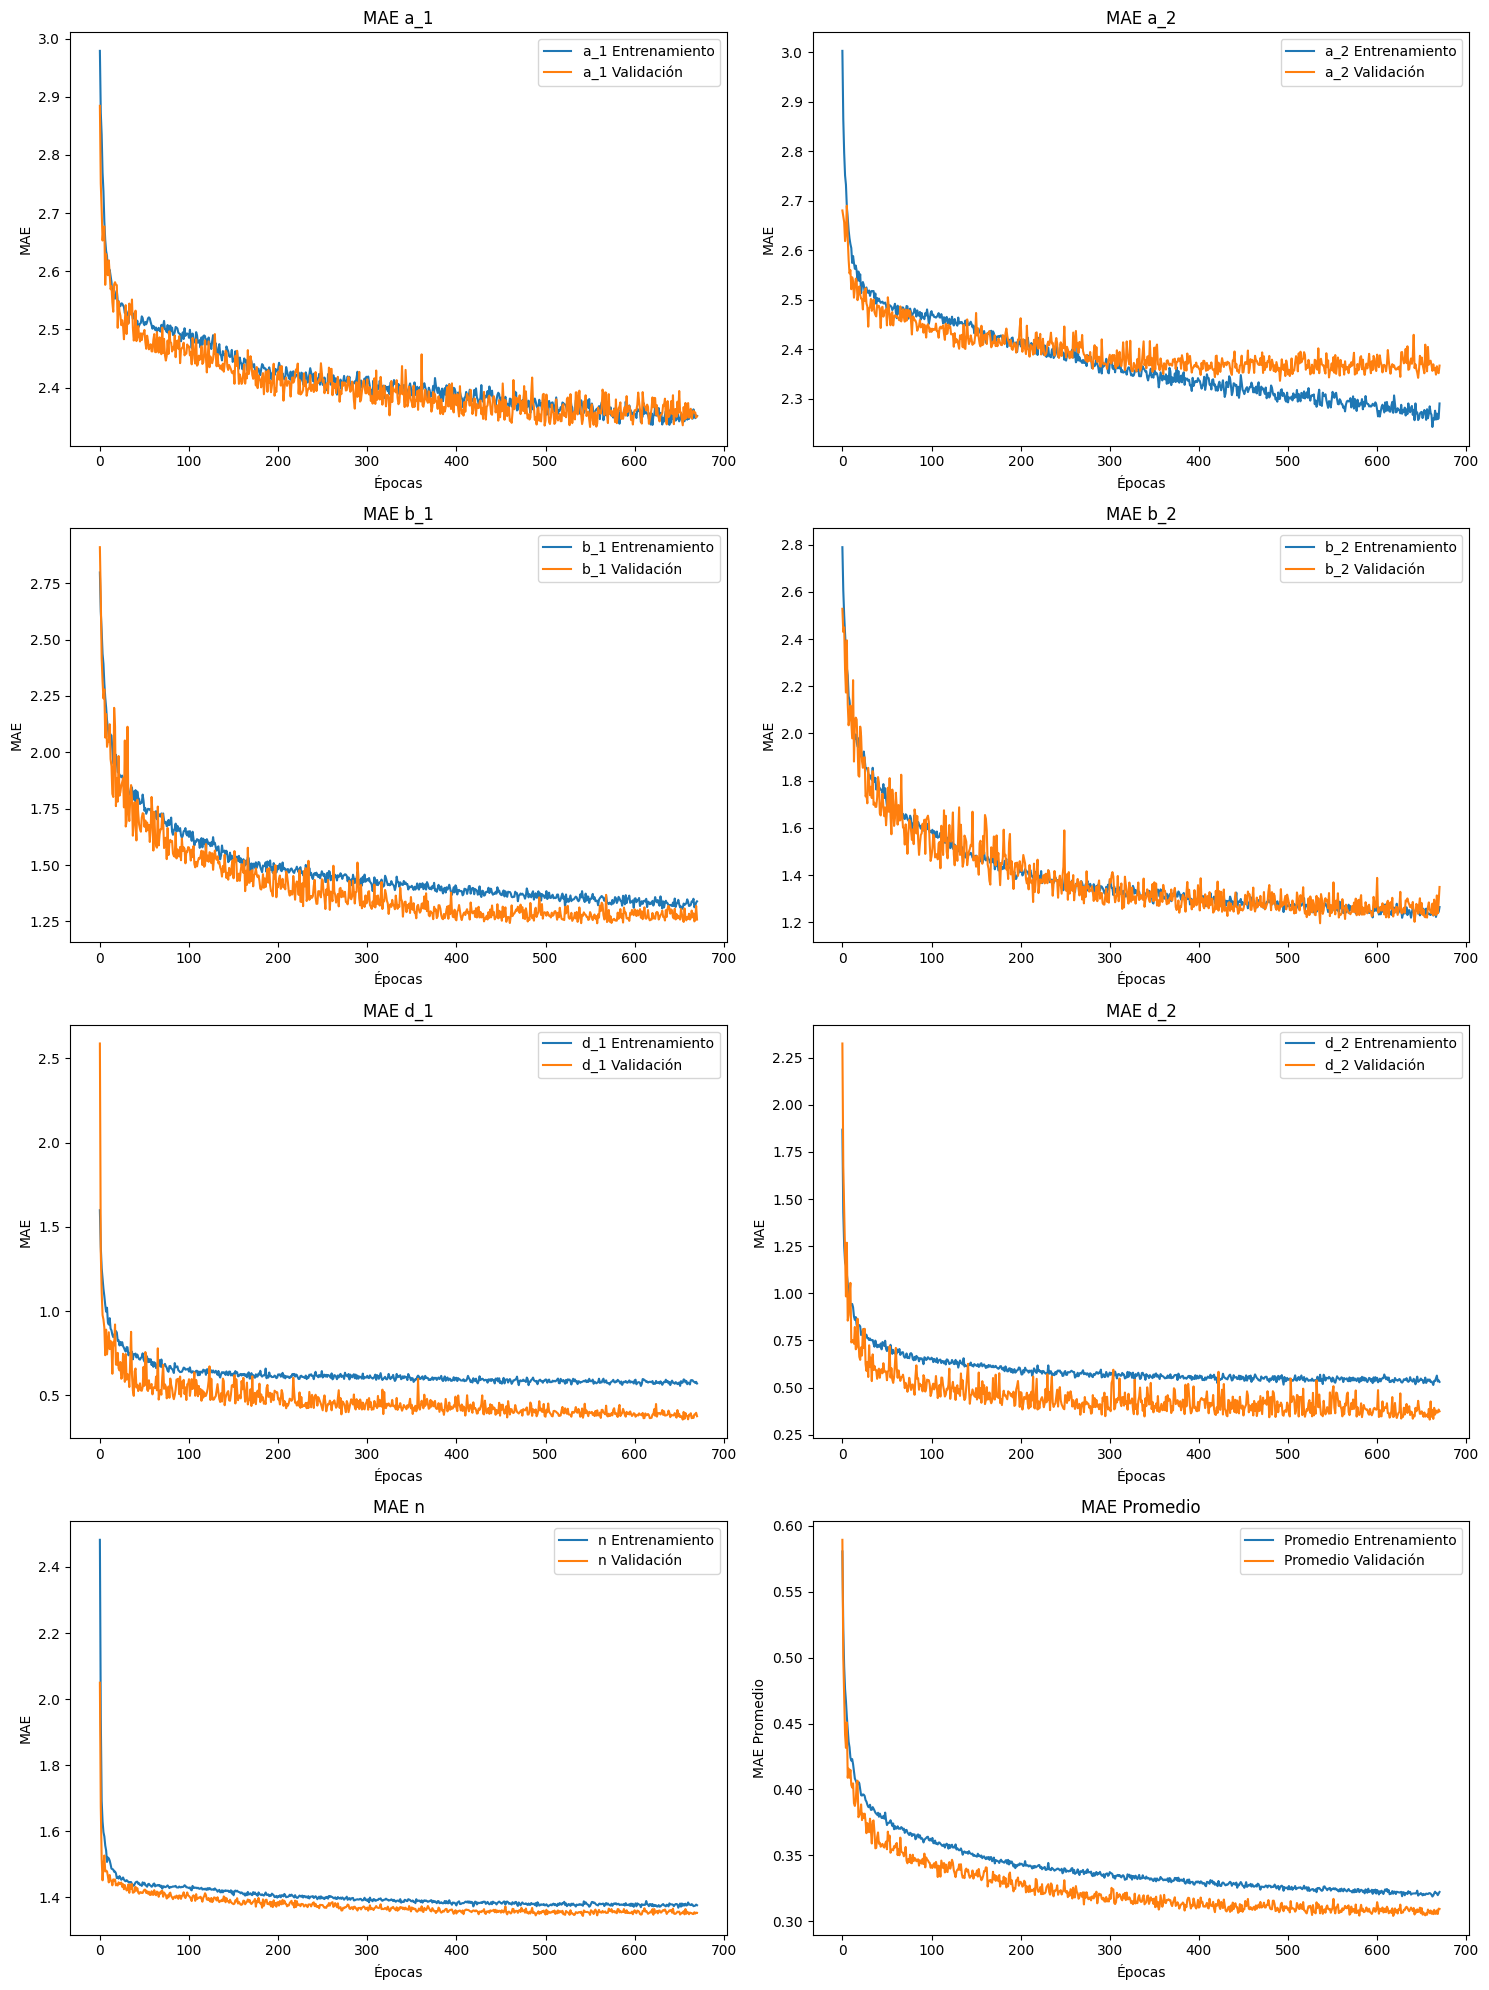

In [51]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [52]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

63/63 [==============================] - 0s 997us/step - loss: 3.8165 - a_1: 2.3166 - a_2: 2.4093 - b_1: 1.2323 - b_2: 1.1512 - d_1: 0.3782 - d_2: 0.3904 - n: 1.3638 - mean_metric: 0.3055


In [53]:
predictions = model.predict(varftest)

63/63 [==============================] - 0s 868us/step


In [54]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.3208281667201913, Desviación estándar del error: 1.862773531095326, Error absoluto máximo: 8.761919975280762


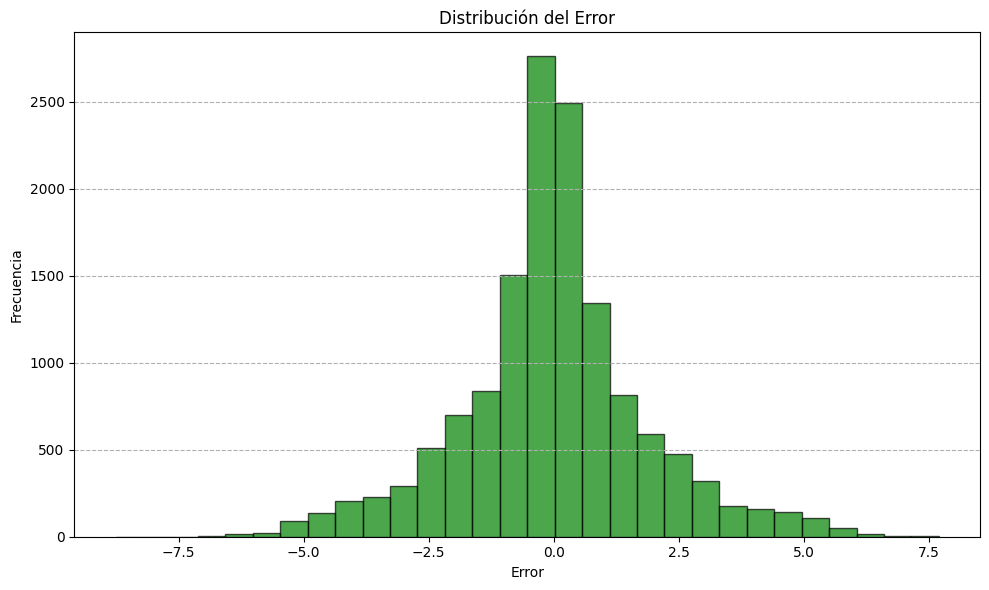

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [56]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")

MAE relativo: 0.3074448679223335
Desviación estándar del error relativo: 0.17656405306733103
Error absoluto máximo relativo: 1.714326710999012


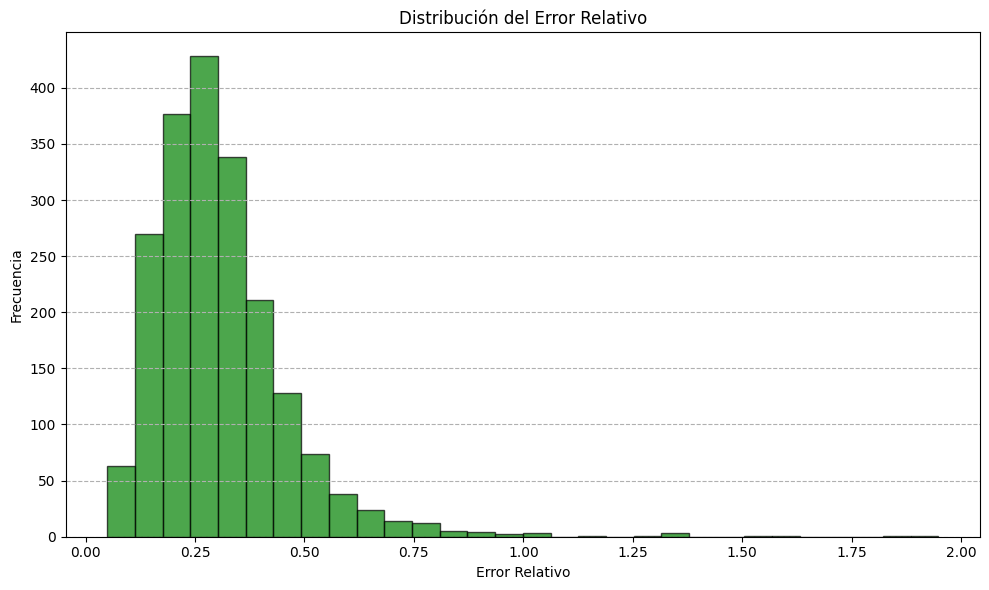

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos Accuracy y Loss

In [58]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 50,100/historytrayec100.csv', index=False)

# Guardamos el modelo

In [59]:
path_to_save = '../../../Modelos con ruido/Modelos 50,100'

In [60]:
model.save(path_to_save + '/trayectorias100.h5')

# Importamos el modelo

In [1]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [2]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [3]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 50,100/trayectorias100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [64]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.05
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[4, 9, 10, 2, 5, 5, 1]
(10, 2, 100)


In [65]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [66]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 50ms/step
[[7. 6. 9. 4. 4. 5. 2.]]


## Graficamos con los coeficientes reales

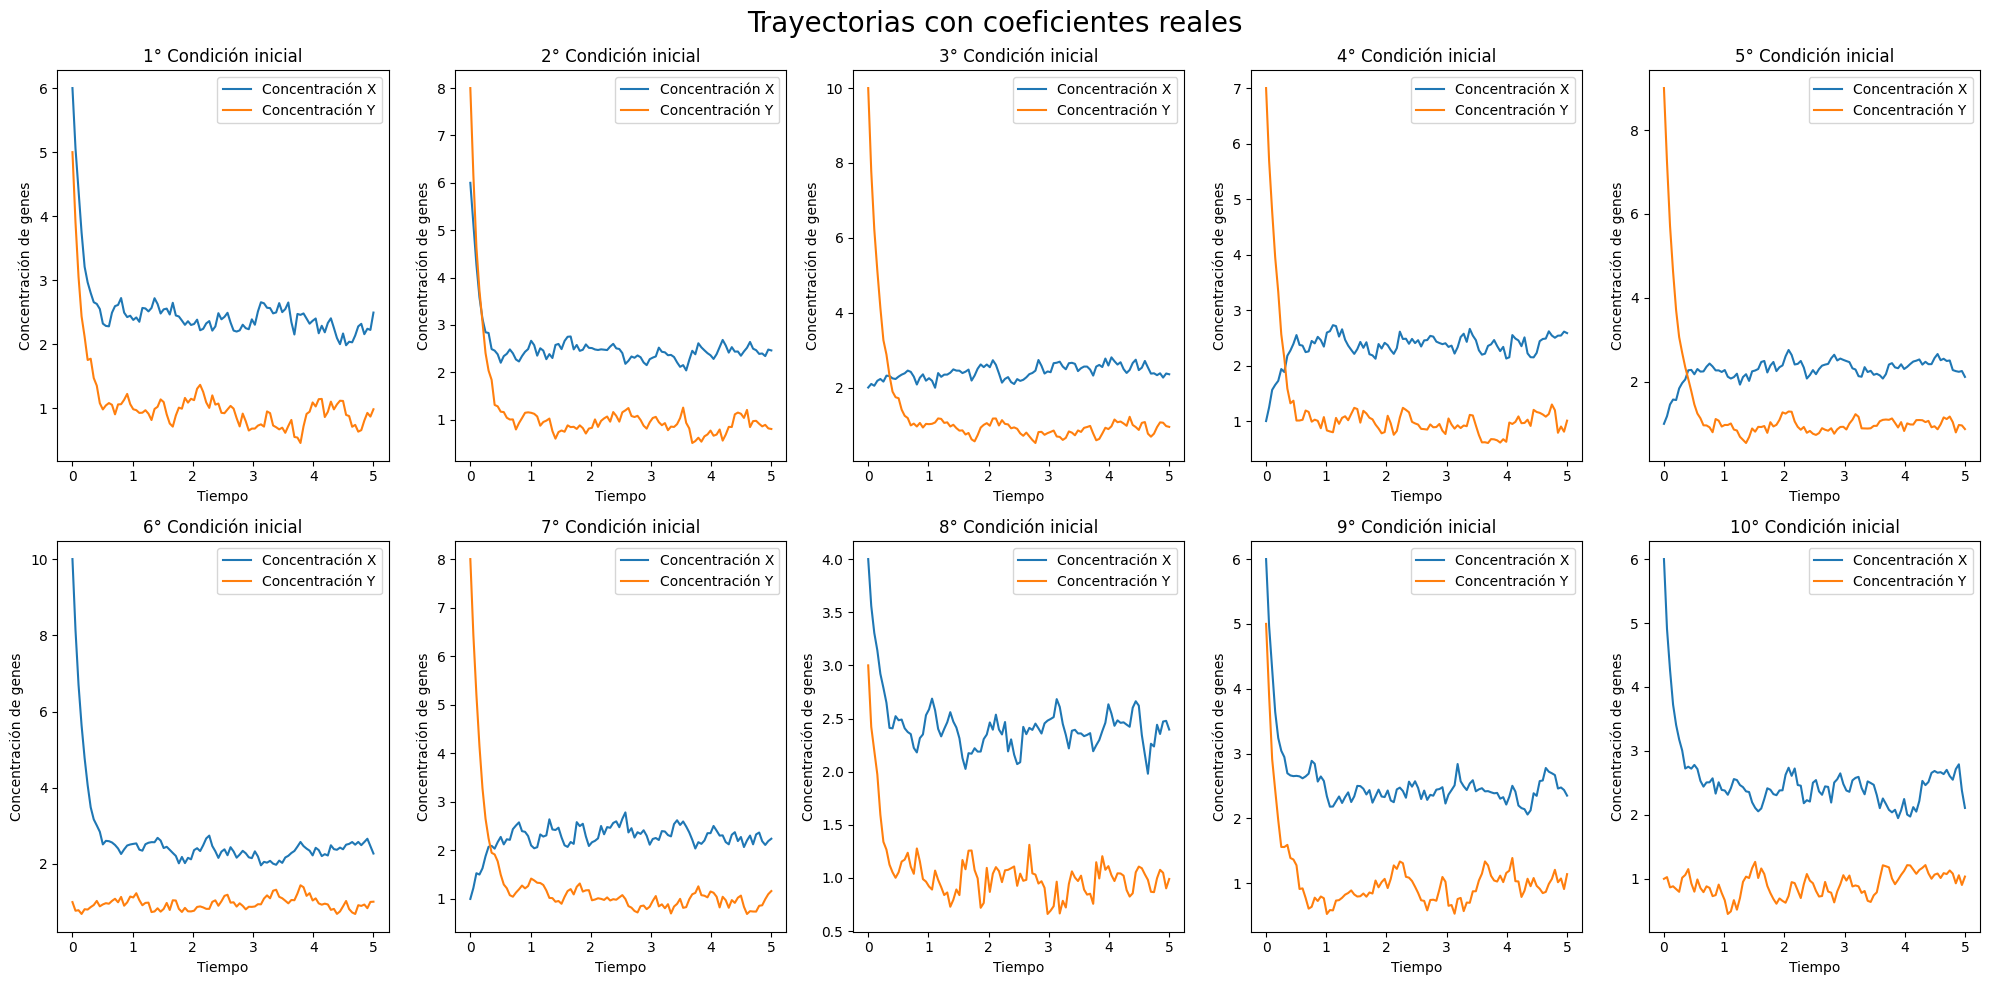

In [67]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [68]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

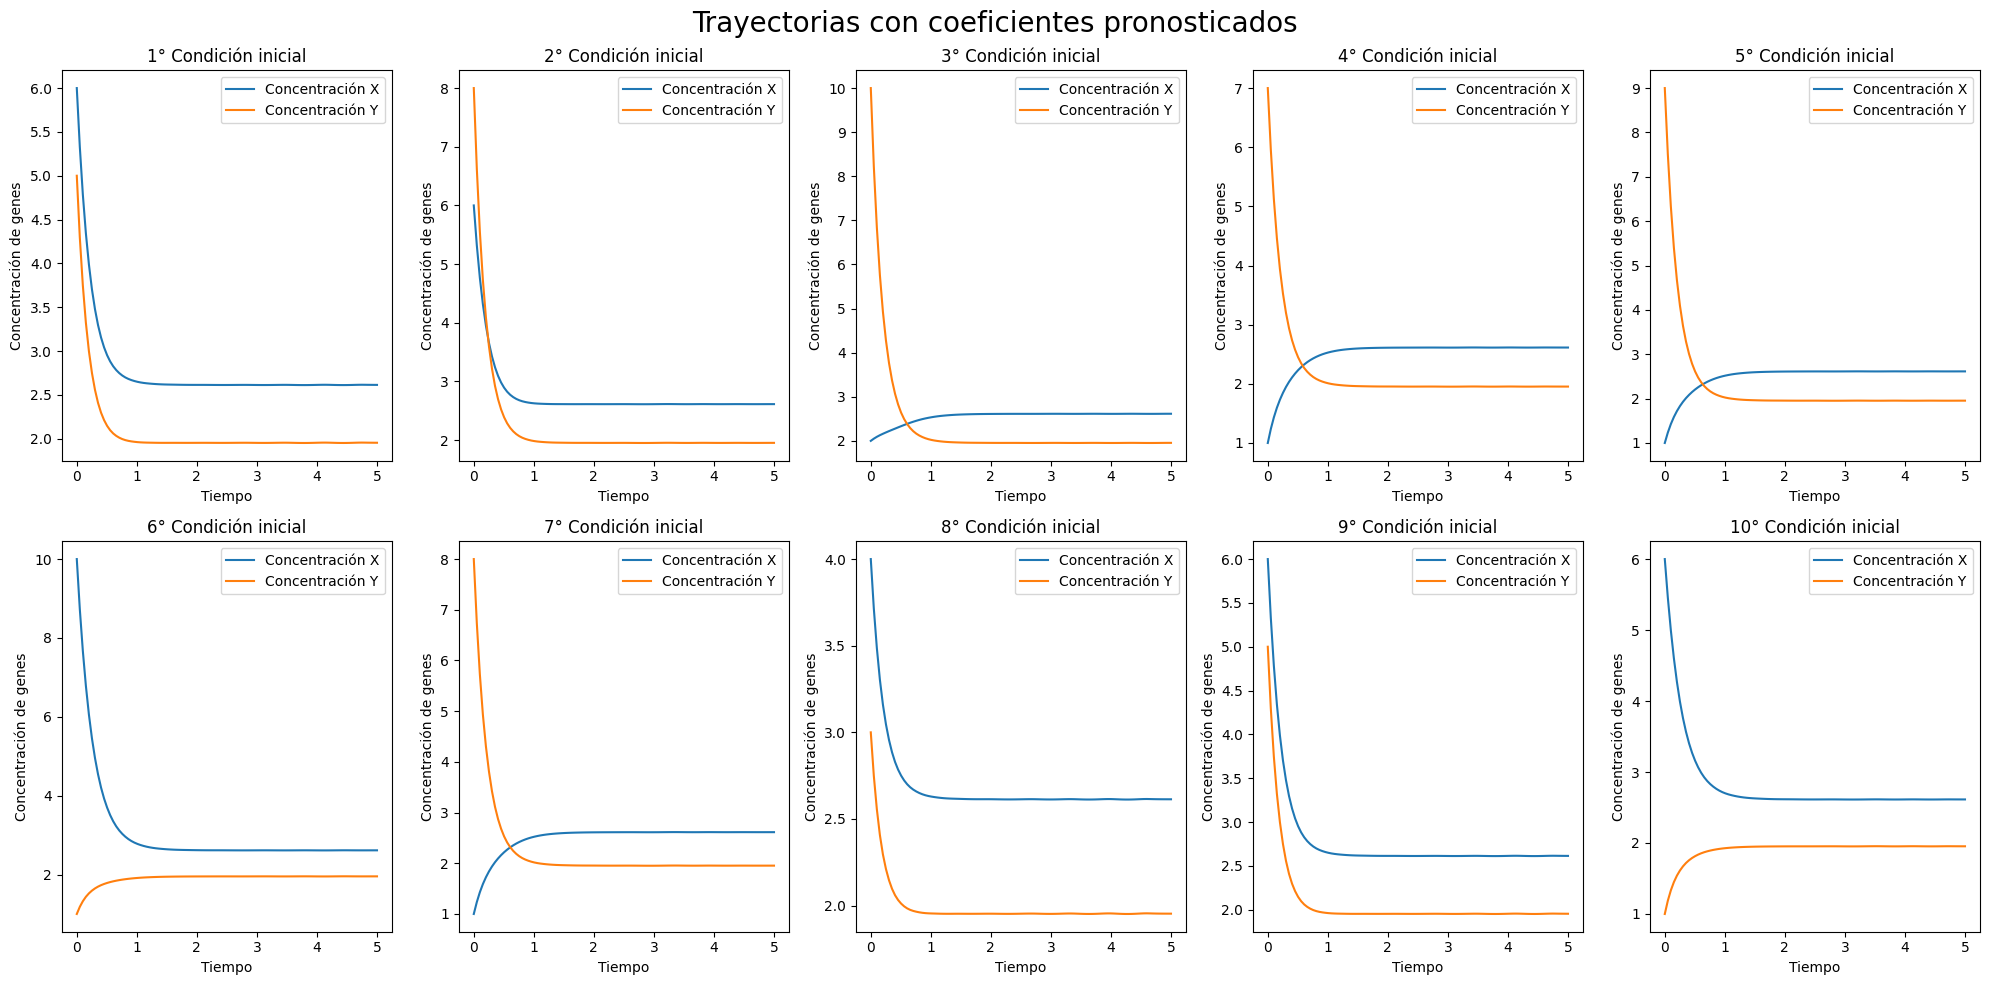

In [69]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

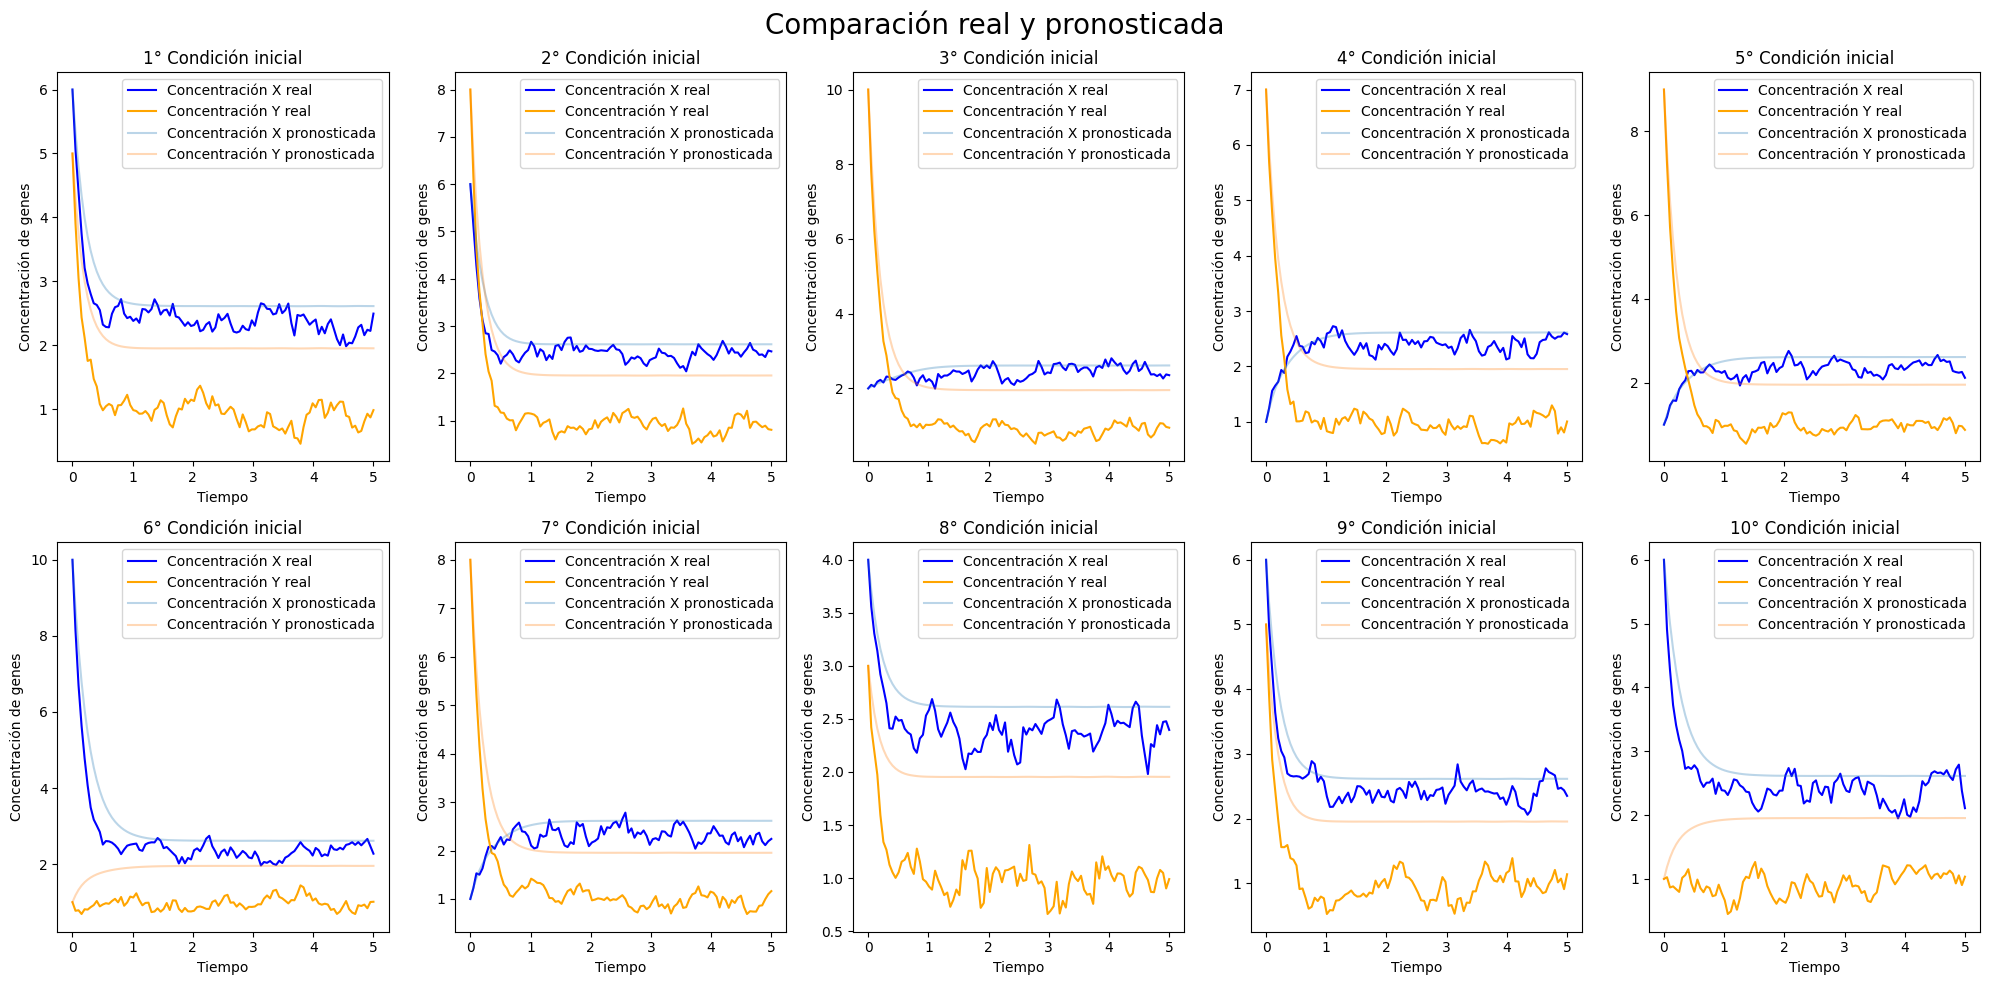

In [70]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

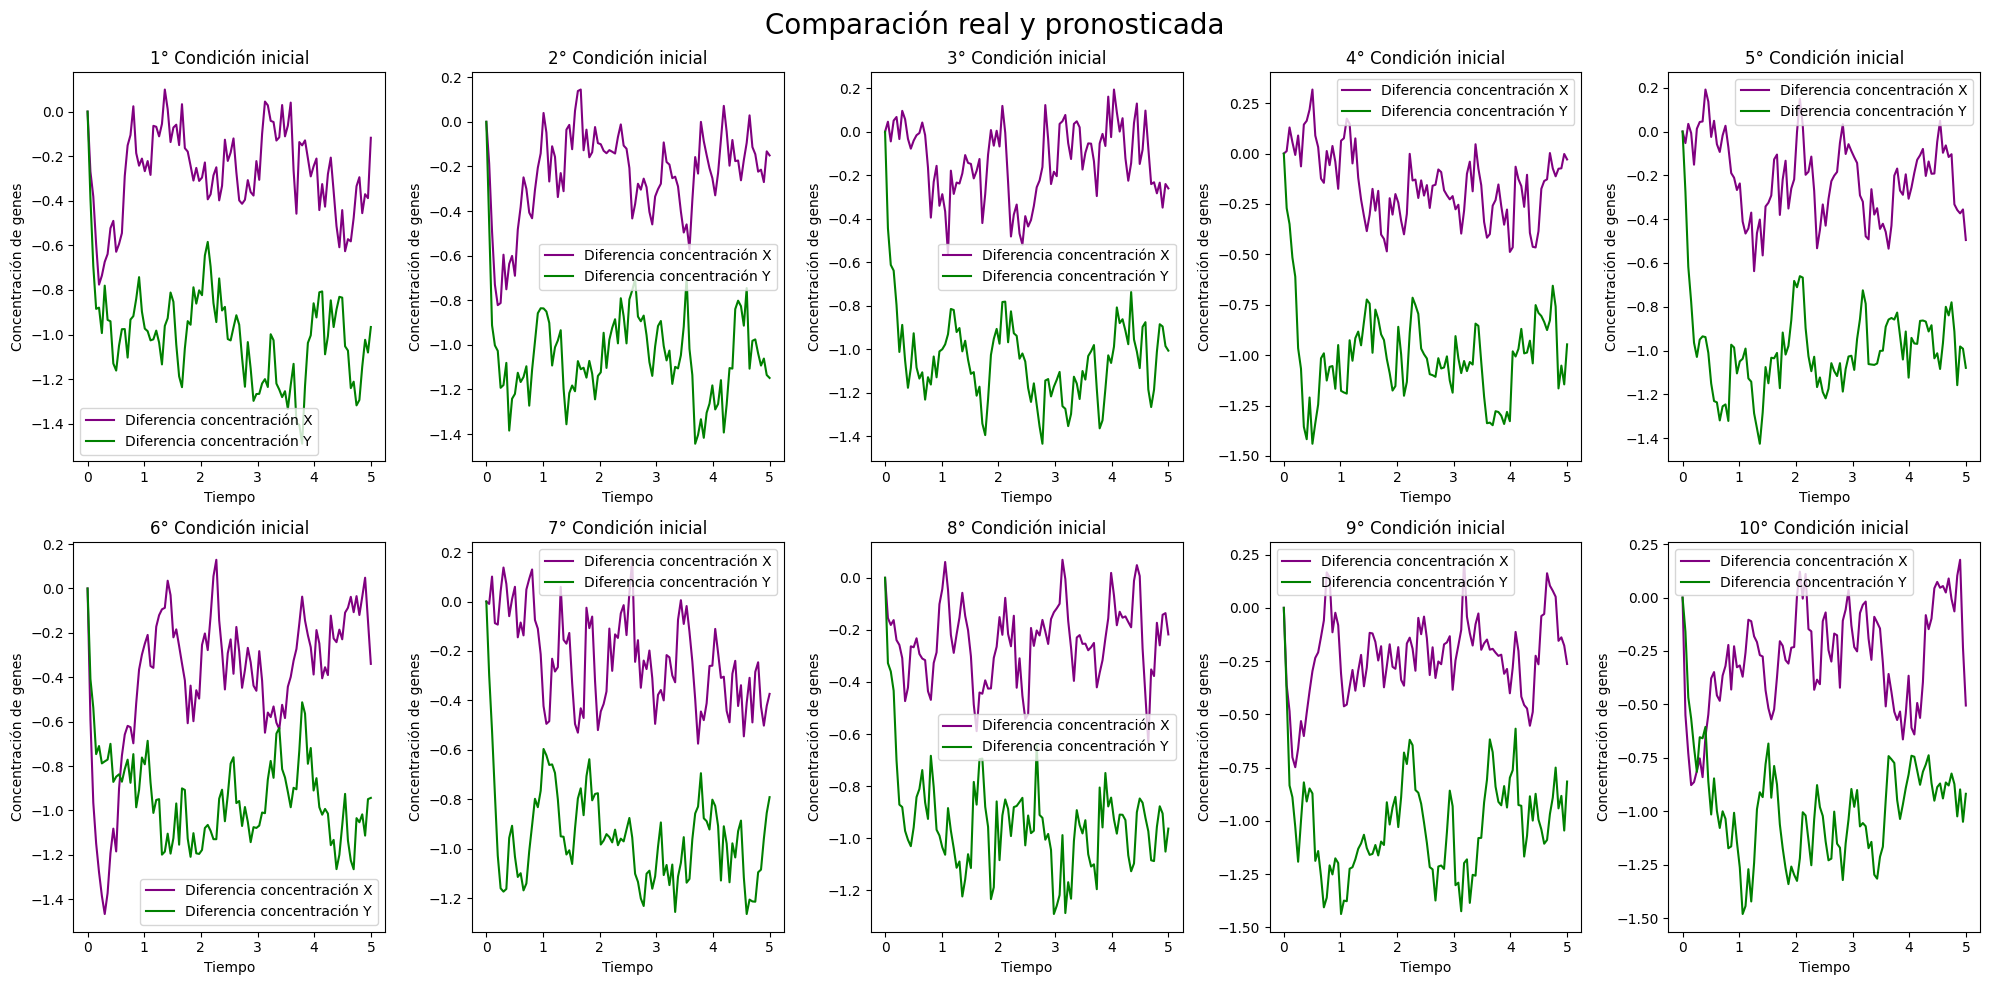

In [71]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [72]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.1280093701912232
0.4952388529093249


## Diferencias relativas

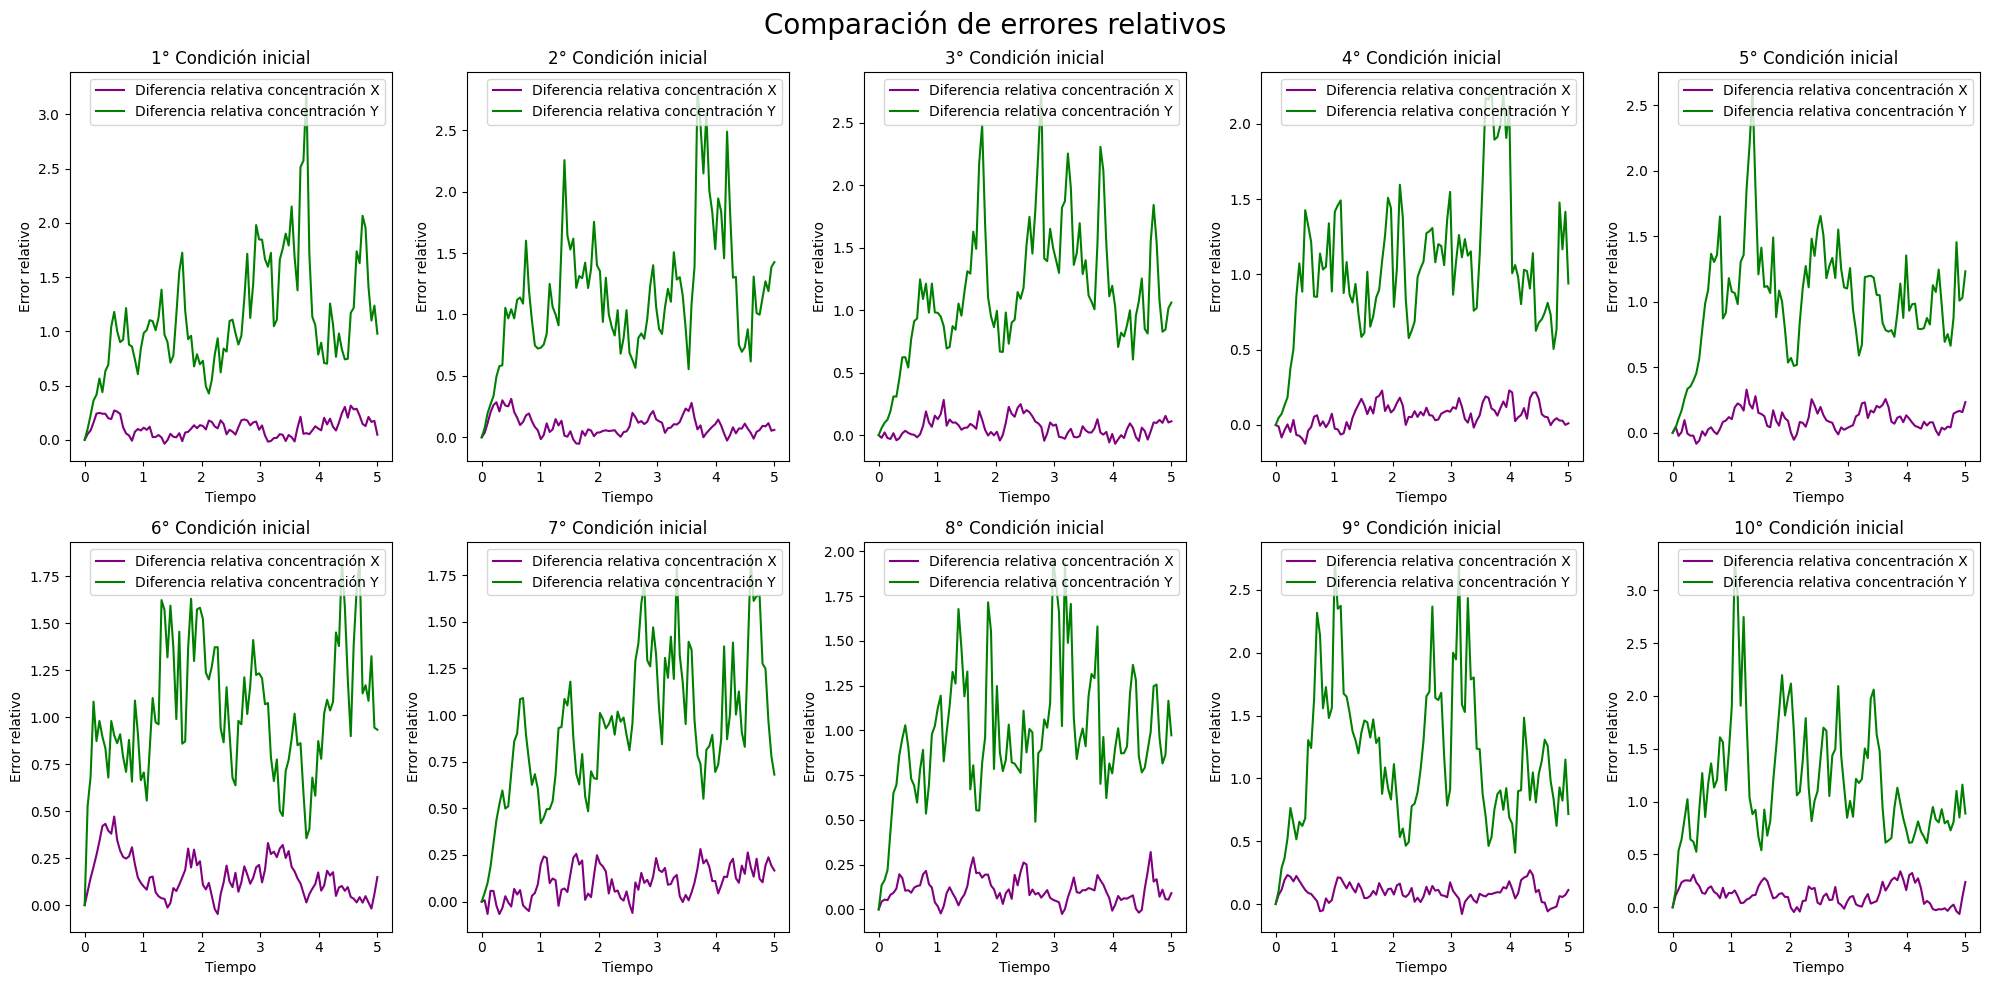

Suma mayor error relativo 129.43559953457506
Número de condición inicial 10


In [73]:
# Vamos a crear una lista para almacenar las sumas de los errores relativos para X y Y
sum_relative_errors_X = []
sum_relative_errors_Y = []

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # Diferencia relativa
    # Asegurándonos de evitar divisiones por cero
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, (pred_X - real_X) / real_X, 0)
    relative_diff_Y = np.where(real_Y != 0, (pred_Y - real_Y) / real_Y, 0)
    
    axes[i].plot(times, relative_diff_X, label=f"Diferencia relativa concentración X", alpha=1, color="purple")
    axes[i].plot(times, relative_diff_Y, label=f"Diferencia relativa concentración Y", alpha=1, color="g")
    
    # Suma de los errores relativos
    sum_relative_errors_X.append(np.sum(np.abs(relative_diff_X)))
    sum_relative_errors_Y.append(np.sum(np.abs(relative_diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Error relativo')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación de errores relativos', fontsize=20)

plt.tight_layout()
plt.show()

# Podrías encontrar el máximo error relativo de la misma forma que el error absoluto
sum_total_relative_errors = [ex + ey for ex, ey in zip(sum_relative_errors_X, sum_relative_errors_Y)]
max_relative_error = max(sum_total_relative_errors)
index_max_relative_error = sum_total_relative_errors.index(max_relative_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico

print('Suma mayor error relativo', max_relative_error)
print('Número de condición inicial',index_max_relative_error)

## Error relativo global

In [74]:
# Vamos a crear listas para almacenar el máximo error relativo y el tiempo en que ocurre para cada condición inicial
max_relative_errors_X = []
max_relative_errors_Y = []
times_max_error_X = []
times_max_error_Y = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Encontrar el valor máximo y el tiempo en el que ocurre
    max_error_X = np.max(np.abs(relative_diff_X))
    max_error_Y = np.max(np.abs(relative_diff_Y))
    time_max_error_X = times[np.argmax(relative_diff_X)]
    time_max_error_Y = times[np.argmax(relative_diff_Y)]
    
    max_relative_errors_X.append(max_error_X)
    max_relative_errors_Y.append(max_error_Y)
    times_max_error_X.append(time_max_error_X)
    times_max_error_Y.append(time_max_error_Y)

# Ahora puedes encontrar el error relativo máximo global y la condición inicial y tiempo en el que ocurre
global_max_error_X = max(max_relative_errors_X)
global_max_error_Y = max(max_relative_errors_Y)

index_global_max_error_X = max_relative_errors_X.index(global_max_error_X) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
index_global_max_error_Y = max_relative_errors_Y.index(global_max_error_Y) + 1

time_global_max_error_X = times_max_error_X[index_global_max_error_X - 1]  # Restamos 1 para ajustar el índice a la lista de Python
time_global_max_error_Y = times_max_error_Y[index_global_max_error_Y - 1]

print(f"El error relativo máximo para X es {global_max_error_X*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_X)
print("Ocurre en el tiempo:", time_global_max_error_X)

print(f"El error relativo máximo para Y es {global_max_error_Y*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_error_Y)
print("Ocurre en el tiempo:", time_global_max_error_Y)

El error relativo máximo para X es 47.13%
Ocurre en la condición inicial número: 6
Ocurre en el tiempo: 0.5050505050505051
El error relativo máximo para Y es 328.87%
Ocurre en la condición inicial número: 10
Ocurre en el tiempo: 1.0606060606060606


In [75]:

# Vamos a crear una lista para almacenar el máximo error relativo combinado (X + Y) y los tiempos en los que ocurre para cada condición inicial
max_combined_relative_errors = []
times_max_combined_error = []

for i in range(10):
    # Calcular la diferencia relativa como antes
    real_X = np.array(varf)[i, 0, :]
    real_Y = np.array(varf)[i, 1, :]
    
    pred_X = np.array(varfpred)[i, 0, :]
    pred_Y = np.array(varfpred)[i, 1, :]
    
    relative_diff_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
    relative_diff_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
    
    # Calculamos la suma de los errores relativos en X y Y para cada punto en el tiempo
    combined_relative_error = relative_diff_X + relative_diff_Y
    
    # Encontramos el valor máximo y el tiempo en el que ocurre
    max_combined_error = np.max(combined_relative_error)
    time_max_combined_error = times[np.argmax(combined_relative_error)]
    
    max_combined_relative_errors.append(max_combined_error)
    times_max_combined_error.append(time_max_combined_error)

# Ahora puedes encontrar el error relativo combinado máximo global y la condición inicial y tiempo en que ocurre
global_max_combined_error = max(max_combined_relative_errors)
index_global_max_combined_error = max_combined_relative_errors.index(global_max_combined_error) + 1  # Sumamos 1 porque las condiciones iniciales empiezan desde 1 en tu gráfico
time_global_max_combined_error = times_max_combined_error[index_global_max_combined_error - 1]  # Restamos 1 para ajustar el índice a la lista de Python

print(f"El error relativo combinado máximo (X + Y) es {global_max_combined_error*100:.2f}%")
print("Ocurre en la condición inicial número:", index_global_max_combined_error)
print("Ocurre en el tiempo:", time_global_max_combined_error)

El error relativo combinado máximo (X + Y) es 344.88%
Ocurre en la condición inicial número: 10
Ocurre en el tiempo: 1.0606060606060606


## Hacemos esto n veces

In [4]:
# Importando las librerías necesarias
import numpy as np
import random
from scipy.integrate import solve_ivp


todas_diferencias_relativas_X = []
todas_diferencias_relativas_Y = []

# Inicializar las variables para almacenar los errores relativos máximos globales y los coeficientes correspondientes
max_global_error_X = 0
max_global_error_Y = 0
coef_max_error_X = None
coef_max_error_Y = None
coef_max_error_X_pred = None
coef_max_error_Y_pred = None
condinimaxX = None
condinimaxY = None

total_elementos_X = 0
elementos_condicion_X = 0

total_elementos_Y = 0
elementos_condicion_Y = 0

condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.05
N = int(T/dt)

# Realizamos 10 iteraciones
for iteration in range(1000):
    condini = []
    varf = []
    coef = []
    # constantes
    a1 = random.randint(1, 10)
    a2 = random.randint(1, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(1, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def ftrue(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(ftrue, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfcitrue = np.append([var1], [var2], axis=0)
        varfci2.append(varfcitrue)    

    varftrue= varfci2
    varftrue = np.array(varftrue)
    print(coef)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)
    
    varf= varfci2
    varf = np.array(varf)

    
    varfnone = varf[None, :]
    new_predictions = new_model.predict(varfnone)
    new_predictions = np.round(new_predictions)
    print(new_predictions)  

    a1pred = new_predictions[0,0]
    a2pred = new_predictions[0,1]
    b1pred = new_predictions[0,2]
    b2pred = new_predictions[0,3]
    d1pred = new_predictions[0,4]
    d2pred = new_predictions[0,5]
    npred = new_predictions[0,6]
    
    # Verificar si a1pred, a2pred, o npred son iguales a cero
    if a1pred == 0 or a2pred == 0 or npred == 0:
        print("Uno de los coeficientes críticos es cero, saltando esta iteración.")
        continue  # Salta al inicio del bucle for para la próxima iteración

    varfpred = []

    def f_pred(t, y):
        X = y[0]
        Y = y[1]
        dX_dt = a1pred / (1 + Y ** npred) - d1pred * X + b1pred
        dY_dt = a2pred / (1 + X ** npred) - d2pred * Y + b2pred
        return [dX_dt, dY_dt]

    varfci2pred = []
    for i_ci in range(10):
        y0 = condini[i_ci]
        sol = solve_ivp(f_pred, t_span, y0, t_eval=times)
        var1pred = sol.y[0]
        var2pred = sol.y[1]
        varfcipred = np.append([var1pred], [var2pred], axis=0)
        varfci2pred.append(varfcipred)
    varfpred = varfci2pred

    # Inicializar listas para almacenar los errores relativos máximos y medios para todas las iteraciones
    todos_errores_maximos_X = []
    todos_errores_maximos_Y = []
    todos_errores_medios_X = []
    todos_errores_medios_Y = []
    
   # Calcular las diferencias relativas para cada conjunto de condiciones iniciales
    for i in range(10):  # Asumiendo que hay 10 condiciones iniciales
        real_X = np.array(varftrue)[i, 0, :]
        real_Y = np.array(varftrue)[i, 1, :]
        pred_X = np.array(varfpred)[i, 0, :]
        pred_Y = np.array(varfpred)[i, 1, :]
        
        # Calcular las diferencias relativas donde los valores reales no son cero
        diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)
        diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)
        
        elementos_condicion_X += np.sum(diferencia_relativa_X >= 1)
        total_elementos_X += diferencia_relativa_X.size
        
        elementos_condicion_Y += np.sum(diferencia_relativa_Y >= 1)
        total_elementos_Y += diferencia_relativa_Y.size
        
        # Excluir los valores mayores a 100
        diferencia_relativa_X = np.extract(diferencia_relativa_X <= 1, diferencia_relativa_X)
        diferencia_relativa_Y = np.extract(diferencia_relativa_Y <= 1, diferencia_relativa_Y)
    
        
        # Agregar estas diferencias a la lista total
        todas_diferencias_relativas_X.extend(diferencia_relativa_X)
        todas_diferencias_relativas_Y.extend(diferencia_relativa_Y)
        
        
        # Agregar estas diferencias a la lista total
        todas_diferencias_relativas_X.extend(diferencia_relativa_X)
        todas_diferencias_relativas_Y.extend(diferencia_relativa_Y)
        
        # Calcular el error relativo máximo en esta iteración y condición inicial
        max_error_iter_X = np.max(diferencia_relativa_X)
        max_error_iter_Y = np.max(diferencia_relativa_Y)
        
        # Comprobar si estos son nuevos máximos globales
        if max_error_iter_X > max_global_error_X:
            max_global_error_X = max_error_iter_X
            coef_max_error_X = coef  # Coeficientes reales
            coef_max_error_X_pred = new_predictions  # Coeficientes predichos
            condinimaxX = condini
            
        if max_error_iter_Y > max_global_error_Y:
            max_global_error_Y = max_error_iter_Y
            coef_max_error_Y = coef  # Coeficientes reales
            coef_max_error_Y_pred = new_predictions  # Coeficientes predichos
            condinimaxY = condini
            
porcentaje_total_X = (elementos_condicion_X / total_elementos_X) * 100
porcentaje_total_Y = (elementos_condicion_Y / total_elementos_Y) * 100


# Convertir las listas a arreglos NumPy para facilitar los cálculos
todas_diferencias_relativas_X = np.array(todas_diferencias_relativas_X)
todas_diferencias_relativas_Y = np.array(todas_diferencias_relativas_Y)

# Calcular e imprimir los errores relativos medios y máximos globales
print(f"Error relativo medio global para X: {np.mean(todas_diferencias_relativas_X) * 100:.2f}%")
print(f"Error relativo medio global para Y: {np.mean(todas_diferencias_relativas_Y) * 100:.2f}%")
print(f"Error relativo máximo global para X: {np.max(todas_diferencias_relativas_X) * 100:.2f}%")
print(f"Error relativo máximo global para Y: {np.max(todas_diferencias_relativas_Y) * 100:.2f}%")

print(f"Coeficientes reales correspondientes para error máximo X: {coef_max_error_X}")
print(f"Coeficientes predichos correspondientes para error máximo X: {coef_max_error_X_pred}")


print(f"Coeficientes reales correspondientes para Y: {coef_max_error_Y}")
print(f"Coeficientes predichos correspondientes para Y: {coef_max_error_Y_pred}")

print(f"En promedio en X, el {porcentaje_total_X:.2f}% de los puntos tiene una diferencia relativa mayir o igual a 100% a lo largo de todas las condiciones iniciales.")
print(f"En promedio en Y , el {porcentaje_total_Y:.2f}% de los puntos tiene una diferencia relativa mayor o igual a 100% a lo largo de todas las condiciones iniciales.")



[[5, 8, 3, 9, 6, 3, 3]]
1/1 [==============================] - 0s 68ms/step
[[5. 8. 3. 7. 6. 3. 3.]]
[[5, 10, 9, 1, 10, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 6.  7.  8.  3. 10.  1.  3.]]
[[9, 5, 8, 1, 8, 8, 3]]
1/1 [==============================] - 0s 11ms/step
[[9. 4. 8. 1. 9. 9. 3.]]
[[4, 5, 10, 6, 3, 2, 4]]
1/1 [==============================] - ETA: 0s

C:\Users\rafae\AppData\Local\Temp\ipykernel_7188\2143562672.py:166: RuntimeWarning: invalid value encountered in true_divide
  diferencia_relativa_Y = np.where(real_Y != 0, np.abs((pred_Y - real_Y) / real_Y), 0)


1/1 [==============================] - 0s 10ms/step
[[5. 5. 8. 5. 3. 2. 2.]]
[[5, 5, 0, 5, 4, 2, 3]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 0. 6. 4. 2. 3.]]
[[10, 7, 8, 7, 4, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 7. 8. 4. 1. 2.]]
[[8, 1, 3, 7, 4, 2, 2]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 3. 4. 4. 1. 3.]]
[[6, 6, 2, 4, 3, 7, 2]]


C:\Users\rafae\AppData\Local\Temp\ipykernel_7188\2143562672.py:165: RuntimeWarning: invalid value encountered in true_divide
  diferencia_relativa_X = np.where(real_X != 0, np.abs((pred_X - real_X) / real_X), 0)


1/1 [==============================] - 0s 11ms/step
[[4. 5. 5. 6. 4. 9. 2.]]
[[6, 4, 0, 3, 1, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  5.  2.  4.  1. 10.  2.]]
[[2, 2, 7, 5, 10, 5, 3]]
1/1 [==============================] - 0s 14ms/step
[[ 5.  4.  5.  4. 10.  5.  2.]]
[[6, 5, 3, 7, 10, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  5.  2.  7. 10.  4.  2.]]
[[4, 3, 1, 8, 5, 4, 1]]
1/1 [==============================] - 0s 12ms/step
[[4. 4. 2. 8. 5. 4. 2.]]
[[3, 1, 10, 1, 5, 5, 5]]
1/1 [==============================] - 0s 11ms/step
[[6. 5. 9. 1. 5. 6. 3.]]
[[2, 5, 7, 8, 10, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  5.  7.  8. 10. 10.  2.]]
[[1, 4, 5, 4, 6, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 3.  5.  4.  4.  6. 10.  2.]]
[[5, 2, 8, 1, 10, 6, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  3.  8.  1. 10.  6.  2.]]
[[9, 8, 1, 9, 7, 8, 5]]
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 11ms/step
[[5. 6. 3. 9. 5. 5. 2.]]
[[2, 2, 9, 4, 6, 6, 5]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 7. 3. 6. 6. 2.]]
[[8, 10, 5, 9, 0, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 7.  5.  6.  8.  0. 10.  3.]]
[[8, 6, 7, 8, 6, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[6. 6. 9. 9. 6. 7. 2.]]
[[6, 4, 1, 3, 0, 7, 1]]
1/1 [==============================] - 0s 10ms/step
[[3. 5. 3. 4. 0. 8. 2.]]
[[10, 6, 3, 8, 6, 7, 4]]
1/1 [==============================] - 0s 12ms/step
[[5. 8. 4. 7. 7. 7. 3.]]
[[5, 6, 5, 7, 8, 0, 5]]
1/1 [==============================] - 0s 10ms/step
[[5. 6. 5. 8. 9. 0. 3.]]
[[2, 3, 8, 8, 2, 2, 1]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 6. 5. 2. 1. 2.]]
[[3, 1, 8, 6, 0, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 8. 6. 0. 1. 2.]]
[[5, 4, 2, 4, 3, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[5. 4. 2. 3. 2. 0. 3.]]
[[1,

1/1 [==============================] - 0s 10ms/step
[[ 4.  9.  3.  9.  7. 10.  3.]]
[[3, 10, 10, 0, 10, 10, 3]]
1/1 [==============================] - 0s 13ms/step
[[ 5.  4.  7.  2. 10. 10.  3.]]
[[7, 7, 1, 7, 4, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[5. 7. 1. 7. 3. 8. 3.]]
[[10, 4, 3, 3, 1, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[8. 5. 7. 3. 1. 8. 3.]]
[[4, 3, 3, 0, 0, 4, 1]]
1/1 [==============================] - 0s 12ms/step
[[3. 5. 2. 1. 0. 5. 3.]]
[[5, 1, 8, 9, 0, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[7. 5. 8. 8. 0. 9. 2.]]
[[5, 3, 8, 4, 2, 5, 5]]
1/1 [==============================] - 0s 10ms/step
[[6. 5. 7. 3. 2. 6. 3.]]
[[9, 4, 7, 6, 6, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[4. 4. 7. 7. 6. 4. 2.]]
[[9, 4, 3, 3, 10, 7, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 8.  4.  2.  4. 10.  7.  4.]]
[[4, 2, 8, 8, 2, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 6. 8

1/1 [==============================] - 0s 10ms/step
[[6. 6. 8. 6. 8. 5. 2.]]
[[5, 8, 0, 9, 9, 0, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  7.  1.  9. 10.  0.  3.]]
[[2, 5, 8, 9, 7, 10, 2]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  6.  7.  9.  7. 10.  2.]]
[[9, 9, 6, 3, 7, 2, 4]]
1/1 [==============================] - 0s 11ms/step
[[5. 8. 6. 8. 7. 3. 3.]]
[[3, 1, 5, 1, 2, 1, 4]]
1/1 [==============================] - 0s 12ms/step
[[5. 5. 6. 2. 2. 1. 3.]]
[[10, 2, 4, 1, 1, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 6. 6. 1. 1. 2.]]
[[10, 7, 7, 5, 8, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[6. 6. 8. 5. 8. 5. 3.]]
[[1, 1, 3, 8, 8, 1, 3]]
1/1 [==============================] - 0s 11ms/step
[[4. 4. 2. 8. 9. 2. 2.]]
[[4, 10, 5, 0, 6, 1, 1]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 6. 3. 6. 1. 3.]]
[[3, 10, 1, 2, 8, 10, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 3.  8.  1.  3.  

1/1 [==============================] - 0s 10ms/step
[[5. 4. 8. 3. 0. 9. 2.]]
[[10, 9, 9, 7, 0, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 8. 6. 0. 6. 3.]]
[[8, 10, 8, 2, 6, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[8. 5. 8. 4. 5. 8. 3.]]
[[2, 4, 0, 3, 6, 8, 4]]
1/1 [==============================] - 0s 11ms/step
[[1. 3. 0. 4. 6. 9. 2.]]
[[7, 1, 0, 5, 0, 3, 3]]
1/1 [==============================] - 0s 12ms/step
[[4. 5. 1. 6. 0. 4. 3.]]
[[5, 3, 1, 3, 0, 8, 5]]
1/1 [==============================] - 0s 11ms/step
[[4. 5. 1. 4. 0. 9. 3.]]
[[4, 10, 6, 8, 6, 8, 2]]
1/1 [==============================] - 0s 12ms/step
[[5. 6. 5. 9. 6. 8. 2.]]
[[6, 2, 4, 0, 4, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 4. 5. 1. 4. 7. 3.]]
[[10, 3, 1, 8, 3, 3, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 6. 2. 9. 3. 4. 2.]]
[[9, 2, 4, 6, 6, 10, 3]]
1/1 [==============================] - 0s 11ms/step
[[ 8.  4.  7.  5.  8. 10.  3.]]
[[

1/1 [==============================] - 0s 10ms/step
[[4. 5. 3. 6. 1. 6. 2.]]
[[9, 3, 4, 9, 4, 6, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 6. 4. 8. 4. 6. 3.]]
[[4, 8, 3, 2, 10, 0, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  6.  4.  7. 10.  0.  3.]]
[[1, 8, 8, 0, 1, 1, 3]]
1/1 [==============================] - 0s 12ms/step
[[5. 5. 8. 0. 1. 0. 3.]]
[[3, 10, 3, 4, 8, 3, 4]]
1/1 [==============================] - 0s 10ms/step
[[5. 9. 3. 5. 8. 3. 4.]]
[[2, 10, 7, 0, 1, 0, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 8. 3. 2. 0. 2.]]
[[6, 10, 1, 2, 10, 6, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  9.  1.  8. 10.  8.  4.]]
[[8, 9, 0, 5, 6, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[ 4.  9.  2.  5.  5. 10.  3.]]
[[4, 3, 2, 6, 3, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 2. 9. 3. 1. 2.]]
[[1, 7, 6, 7, 0, 9, 3]]
1/1 [==============================] - 0s 12ms/step
[[4. 5. 5. 6.

1/1 [==============================] - 0s 11ms/step
[[5. 5. 3. 8. 0. 3. 2.]]
[[2, 2, 9, 3, 5, 7, 1]]
1/1 [==============================] - 0s 11ms/step
[[3. 4. 6. 3. 4. 7. 2.]]
[[9, 7, 1, 2, 2, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 5. 3. 2. 2. 6. 4.]]
[[7, 7, 6, 5, 1, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[7. 5. 7. 5. 1. 6. 3.]]
[[9, 1, 3, 7, 7, 1, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 4. 3. 4. 8. 1. 3.]]
[[6, 1, 1, 0, 2, 5, 5]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 7. 1. 3. 6. 3.]]
[[6, 3, 5, 0, 8, 9, 2]]
1/1 [==============================] - 0s 10ms/step
[[ 6.  3.  5.  1.  9. 10.  3.]]
[[2, 2, 4, 6, 3, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[5. 6. 2. 4. 2. 2. 3.]]
[[7, 7, 8, 10, 0, 5, 2]]
1/1 [==============================] - 0s 10ms/step
[[6. 5. 6. 8. 0. 5. 2.]]
[[5, 3, 4, 1, 3, 8, 2]]
1/1 [==============================] - 0s 10ms/step
[[4. 5. 6. 1. 3. 8. 3.]]
[[4, 4

1/1 [==============================] - 0s 11ms/step
[[5. 7. 7. 9. 6. 5. 2.]]
[[2, 5, 0, 5, 7, 3, 1]]
1/1 [==============================] - 0s 10ms/step
[[4. 5. 1. 7. 7. 4. 3.]]
[[8, 9, 7, 3, 8, 9, 1]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  5.  8.  6.  8. 10.  2.]]
[[4, 6, 9, 4, 4, 9, 5]]
1/1 [==============================] - 0s 12ms/step
[[6. 5. 7. 4. 4. 9. 3.]]
[[2, 10, 7, 4, 1, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[6. 5. 8. 3. 1. 4. 3.]]
[[10, 9, 10, 0, 7, 0, 3]]
1/1 [==============================] - 0s 11ms/step
[[6. 5. 9. 1. 7. 0. 2.]]
[[8, 8, 1, 7, 10, 4, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 4.  8.  1.  8. 10.  4.  3.]]
[[4, 10, 5, 1, 3, 10, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  4.  8.  1.  4. 10.  2.]]
[[1, 6, 9, 2, 10, 5, 4]]
1/1 [==============================] - 0s 10ms/step
[[ 4.  6.  7.  3. 10.  6.  2.]]
[[7, 8, 6, 6, 5, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[5.

1/1 [==============================] - 0s 10ms/step
[[7. 7. 8. 2. 6. 4. 3.]]
[[8, 1, 2, 5, 5, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 3. 3. 4. 0. 2.]]
[[8, 10, 3, 0, 6, 6, 4]]
1/1 [==============================] - 0s 11ms/step
[[7. 4. 3. 1. 5. 6. 3.]]
[[5, 10, 3, 2, 5, 3, 5]]
1/1 [==============================] - 0s 10ms/step
[[6. 9. 2. 3. 5. 3. 4.]]
[[4, 2, 5, 5, 3, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 5. 4. 5. 3. 6. 3.]]
[[3, 10, 2, 6, 2, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 2. 8. 2. 1. 3.]]
[[7, 1, 1, 7, 4, 10, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  4.  2.  7.  4. 10.  2.]]
[[6, 4, 1, 3, 9, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[6. 4. 1. 3. 9. 5. 3.]]
[[2, 6, 4, 0, 4, 1, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 3. 5. 3. 4. 1. 2.]]
[[5, 2, 3, 8, 2, 8, 4]]
1/1 [==============================] - 0s 12ms/step
[[6. 5. 2. 8. 1. 9. 3.]]
[[4

1/1 [==============================] - 0s 10ms/step
[[4. 4. 1. 9. 1. 7. 2.]]
[[4, 7, 7, 8, 8, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 6. 6. 7. 8. 9. 3.]]
[[7, 8, 6, 2, 6, 4, 5]]
1/1 [==============================] - 0s 10ms/step
[[6. 5. 8. 3. 6. 5. 3.]]
[[9, 6, 7, 8, 10, 2, 5]]
1/1 [==============================] - 0s 9ms/step
[[ 5.  6.  6.  7. 10.  2.  2.]]
[[4, 1, 4, 9, 2, 7, 2]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 5. 8. 2. 8. 2.]]
[[10, 6, 4, 3, 6, 4, 3]]
1/1 [==============================] - 0s 11ms/step
[[6. 7. 4. 2. 6. 4. 3.]]
[[3, 1, 1, 8, 1, 5, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 3. 7. 1. 5. 2.]]
[[1, 9, 8, 7, 9, 6, 2]]
1/1 [==============================] - 0s 11ms/step
[[5. 7. 7. 9. 9. 7. 2.]]
[[9, 3, 7, 2, 3, 7, 4]]
1/1 [==============================] - 0s 12ms/step
[[8. 5. 5. 2. 2. 7. 4.]]
[[5, 10, 8, 0, 7, 9, 5]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  4.  8.  1.  6. 10.  2.]

[[6. 5. 8. 7. 1. 8. 2.]]
[[5, 2, 10, 5, 9, 5, 5]]
1/1 [==============================] - 0s 12ms/step
[[6. 4. 9. 4. 9. 5. 2.]]
[[5, 4, 6, 8, 8, 2, 4]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 6. 7. 8. 2. 2.]]
[[5, 2, 3, 8, 7, 5, 1]]
1/1 [==============================] - 0s 10ms/step
[[5. 4. 4. 7. 7. 5. 2.]]
[[1, 2, 0, 4, 7, 8, 5]]
1/1 [==============================] - 0s 10ms/step
[[1. 3. 0. 4. 7. 8. 2.]]
[[7, 8, 4, 3, 1, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 5. 5. 1. 5. 3.]]
[[6, 2, 2, 1, 2, 1, 5]]
1/1 [==============================] - 0s 10ms/step
[[4. 5. 4. 2. 2. 1. 3.]]
[[6, 10, 1, 5, 0, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[4. 5. 2. 5. 0. 4. 3.]]
[[8, 3, 3, 0, 5, 4, 2]]
1/1 [==============================] - 0s 11ms/step
[[8. 3. 6. 0. 6. 5. 3.]]
[[7, 7, 0, 9, 7, 2, 1]]
1/1 [==============================] - 0s 11ms/step
[[4. 6. 1. 9. 7. 2. 3.]]
[[1, 1, 5, 4, 6, 3, 2]]
1/1 [==============================] - 0

1/1 [==============================] - 0s 11ms/step
[[ 8.  4.  8.  1.  8. 10.  3.]]
[[6, 3, 7, 2, 1, 6, 4]]
1/1 [==============================] - 0s 12ms/step
[[7. 5. 8. 2. 1. 6. 3.]]
[[2, 4, 6, 3, 9, 1, 5]]
1/1 [==============================] - 0s 12ms/step
[[5. 5. 5. 3. 9. 1. 3.]]
[[6, 3, 2, 10, 3, 7, 2]]
1/1 [==============================] - 0s 12ms/step
[[4. 4. 3. 9. 3. 7. 2.]]
[[2, 7, 0, 3, 7, 0, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 5. 1. 5. 8. 0. 3.]]
[[8, 7, 0, 3, 8, 3, 4]]
1/1 [==============================] - 0s 11ms/step
[[4. 5. 2. 5. 9. 3. 3.]]
[[6, 2, 7, 10, 3, 2, 1]]
1/1 [==============================] - 0s 12ms/step
[[5. 5. 7. 7. 4. 1. 2.]]
[[8, 7, 8, 9, 8, 9, 3]]
1/1 [==============================] - 0s 10ms/step
[[5. 6. 8. 9. 8. 9. 2.]]
[[10, 8, 8, 7, 9, 9, 5]]
1/1 [==============================] - 0s 11ms/step
[[8. 4. 7. 7. 9. 9. 3.]]
[[1, 4, 5, 9, 9, 4, 5]]
1/1 [==============================] - 0s 12ms/step
[[5. 7. 5. 8. 9. 4. 3.]]
[[9,

1/1 [==============================] - 0s 10ms/step
[[ 4.  3.  7.  3. 10.  6.  2.]]
[[8, 1, 3, 0, 3, 7, 4]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 8. 1. 3. 7. 3.]]
[[7, 1, 1, 7, 9, 10, 1]]
1/1 [==============================] - 0s 12ms/step
[[ 5.  4.  2.  5. 10. 10.  2.]]
[[7, 9, 7, 4, 10, 4, 1]]
1/1 [==============================] - 0s 10ms/step
[[ 5.  4.  8.  7. 10.  5.  2.]]
[[6, 6, 5, 6, 6, 5, 1]]
1/1 [==============================] - 0s 11ms/step
[[5. 4. 6. 8. 6. 5. 2.]]
[[1, 9, 3, 8, 2, 3, 5]]
1/1 [==============================] - 0s 11ms/step
[[5. 5. 3. 8. 2. 3. 3.]]
[[2, 3, 6, 3, 8, 4, 2]]
1/1 [==============================] - 0s 10ms/step
[[4. 3. 5. 3. 8. 4. 2.]]
[[1, 1, 2, 6, 6, 7, 3]]
1/1 [==============================] - 0s 11ms/step
[[2. 3. 1. 5. 6. 7. 2.]]
[[9, 10, 8, 4, 9, 2, 5]]
1/1 [==============================] - 0s 11ms/step
[[ 5.  7.  7.  5. 10.  2.  3.]]
[[4, 3, 1, 3, 1, 5, 4]]
1/1 [==============================] - 0s 11ms/step
[[3. 5. 